#Chef Propagation and Lattice Order

I want to verify that specifying a map order when using chef propagators does not change the simulation. Thus, I will run the foborodobo lattice with sextupoles, tuned on a 3rd integer resonance. I will then specify chef propagators, but a lattice map order of 1. 

- If the map order matters, then the simulation shouldn't show the nonlinear motion introduced by the sextupoles, and instead should produce results as seen in the [1st Order Symplectic Propagation](1st Order Symplectic Propagation.ipynb) notebook. 
- If map order does not matter, then we should see results in line with the [3rd Order Propagation](3rd Order Propagation.ipynb) notebook.

In [1]:
%load_ext watermark
%load_ext autoreload
%autoreload 2

In [2]:
%watermark -d -v -a "Nathan Cook"

Nathan Cook 16/07/2015 

CPython 2.7.10
IPython 3.1.0


In [2]:
import sys, os
import synergia
from mpi4py import MPI
import synergia_workflow

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
#load lattice
lattice = synergia.lattice.Mad8_reader().get_lattice("model16s", "/Users/ncook/Synergia_Tests/lattices/foborodobo_NL.lat")

length = lattice.get_length()
ref = lattice.get_reference_particle() #reference particle
ds = 0.01
nsteps = int(length/ds) +1 #calculate # of steps to take per turn
nsteps_per_element = nsteps/len(lattice.get_elements()) #not this isn't using future division, so returns int

In [4]:
from base_diagnostics import workflow

name = 'model-S-Chef'
order = 1
outputdir = 'order_'+str(order)+'_'+name

opts = workflow.make_opts(name, order, outputdir, nsteps, nsteps_per_element)
workflow.make_path(outputdir)

lattice_simulator = synergia.simulation.Lattice_simulator(lattice,
                                                              opts.map_order)
stepper= synergia.simulation.Independent_stepper(lattice, opts.map_order, opts.steps)

In [5]:
from base_diagnostics import latticework

#define a secondary lattice_simulator for this work

#stepper = synergia.simulation.Independent_stepper_elements(lattice, opts.map_order, opts.steps_per_element)
new_lattice_simulator = stepper.get_lattice_simulator()

x_tune0, y_tune0 = new_lattice_simulator.get_both_tunes()
x_tune1 = 0.33 #place on resonance
y_tune1 = y_tune0 #keep the same if possible
tune_tol = 1.0e-7; #need to define a tolerance for the fit


#specify a set of magnets to be adjusted
f_quads, d_quads = latticework.get_fd_quads(lattice)

#use these magnets to adjust tune to specified final values
new_lattice_simulator.adjust_tunes(x_tune1,y_tune1,f_quads,d_quads,tune_tol)

#update lattice_simulator and get new lattice
new_lattice_simulator.update()
new_lattice = new_lattice_simulator.get_lattice()

#Force define original lattice simulator
lattice = synergia.lattice.Mad8_reader().get_lattice("model16s", "/Users/ncook/Synergia_Tests/lattices/foborodobo_NL.lat")
stepper = synergia.simulation.Independent_stepper_elements(lattice, opts.map_order, opts.steps_per_element)
lattice_simulator = stepper.get_lattice_simulator()


#Print stuff for original lattice
print str(lattice_simulator.get_horizontal_tune()) + " is the original x-tune"
f_quads, d_quads = latticework.get_fd_quads(lattice)
latticework.print_strengths(f_quads)
latticework.print_strengths(d_quads)

#Print stuff for new re-tuned lattice
print str(new_lattice_simulator.get_horizontal_tune()) + " is the new x-tune"
new_f_quads, new_d_quads = latticework.get_fd_quads(new_lattice)
latticework.print_strengths(new_f_quads)
latticework.print_strengths(new_d_quads)

0.0920106680371 is the original x-tune
f K: 0.714285714286
d K: -0.714285714286
0.329999998897 is the new x-tune
f K: 0.761214567067
d K: -0.729172681136


In order to use full chef propagation, we must specify chef propagation for each element. Then, we must use `Independent_stepper_elements` to generate the stepper on an element by element basis.

In [9]:
#specify use_maps
opts.use_maps = 'none'
#Loop through lattice and specify chef propagation.
for elem in new_lattice.get_elements():
    if opts.use_maps == "none":
        elem.set_string_attribute("extractor_type", "chef_propagate")

#Make the stepper via 'independent elements' for full chef
stepper = synergia.simulation.Independent_stepper_elements(new_lattice, opts.map_order, opts.steps_per_element)
#Construct a matched bunch
myBunch = synergia.optics.generate_matched_bunch_transverse(
    new_lattice_simulator, opts.emitx, opts.emity, opts.stdz, 
    opts.dpop, opts.real_particles, 
    opts.macro_particles, opts.seed) 

In [11]:
# Define a bunch simulator
bunch_simulator = synergia.simulation.Bunch_simulator(myBunch)

# Define a set of bunch diagnostics

#basic diagnostics - PER STEP
basicdiag = synergia.bunch.Diagnostics_basic("basic.h5", opts.output_dir)
bunch_simulator.add_per_step(basicdiag)

#include full diagnostics
fulldiag = synergia.bunch.Diagnostics_full2("full.h5", opts.output_dir)
bunch_simulator.add_per_turn(fulldiag)

#tracking diagnostics - PER STEP
diagnostics = synergia.bunch.Diagnostics_track("track.h5", opts.tracked_particles, opts.output_dir)
#Track a particle twice per turn (e.g. every ~ num_steps/2 add the diagnostic)
bunch_simulator.add_per_step(diagnostics)

#particle diagnostics - PER TURN
particlediag = synergia.bunch.Diagnostics_particles("particles.h5",0,0,opts.output_dir)
bunch_simulator.add_per_turn(particlediag)

In [12]:
#Chef map - 2.5s per turn.
propagator = synergia.simulation.Propagator(stepper)
propagator.set_checkpoint_period(opts.checkpointperiod)
propagator.propagate(bunch_simulator, opts.turns, opts.maxturns, 
                     opts.verbosity)

In [16]:
from base_diagnostics import workflow
#clean up files
workflow.cleanup(opts.output_dir)

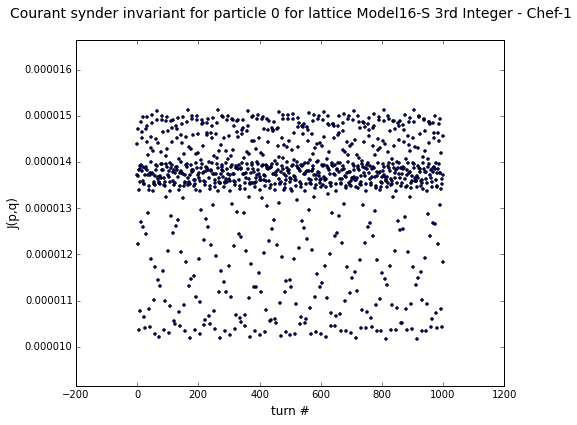

In [18]:
from base_diagnostics import options
from base_diagnostics import singleparticle

popts = options.Options()
popts.lattice_name = 'Model16-S 3rd Integer - Chef-1'
popts.ID = None
popts.path = None
popts.turns = opts.turns 
popts.norm = False
popts.save = True
popts.variance = 0.1
popts.lattice_simulator = lattice_simulator
popts.relpath = opts.output_dir


singleparticle.plot_Invariant(popts)

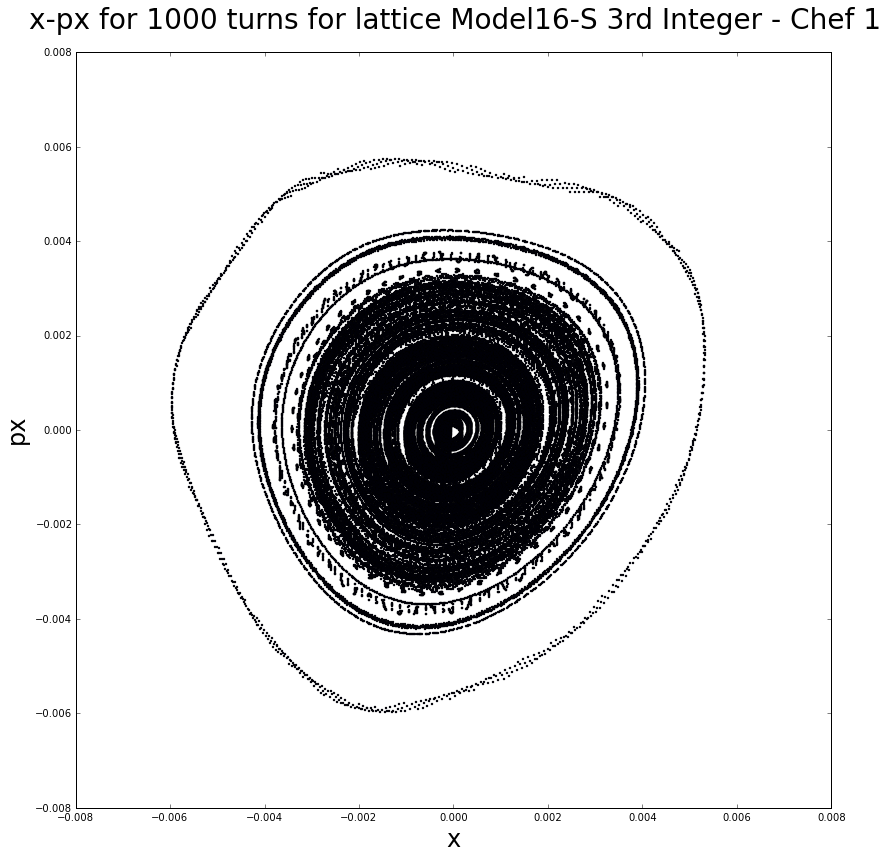

In [24]:
from base_diagnostics import options
from base_diagnostics import singleparticle

popts = options.Options()
popts.lattice_name = 'Model16-S 3rd Integer - Chef 1'
popts.ID = None
popts.path = None
popts.turns = opts.turns 
popts.norm = False
popts.save = True
popts.variance = 0.01
popts.lattice_simulator = lattice_simulator
popts.relpath = opts.output_dir

popts.save = True
popts.plots = ['x','px']
popts.num = 100
popts.scale = 2

singleparticle.plot_Poincare(popts)

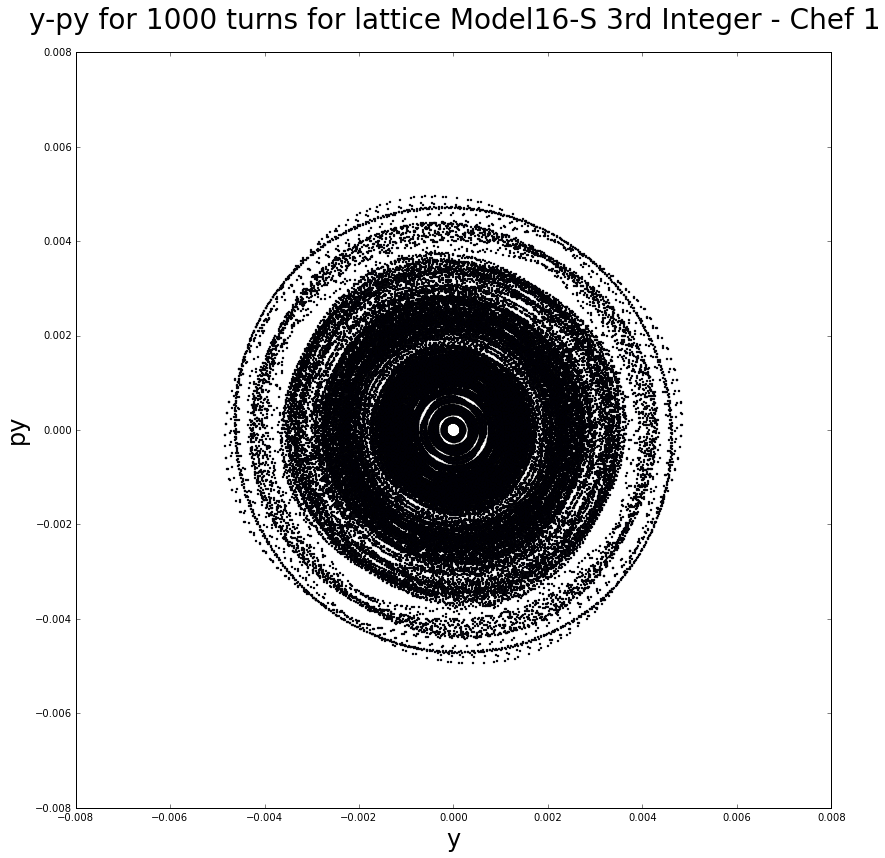

In [25]:
popts = options.Options()
popts.lattice_name = 'Model16-S 3rd Integer - Chef 1'
popts.ID = None
popts.path = None
popts.turns = opts.turns 
popts.norm = False
popts.save = True
popts.variance = 0.01
popts.lattice_simulator = lattice_simulator
popts.relpath = opts.output_dir

popts.save = True
popts.plots = ['y','py']
popts.num = 100
popts.scale = 2

singleparticle.plot_Poincare(popts)

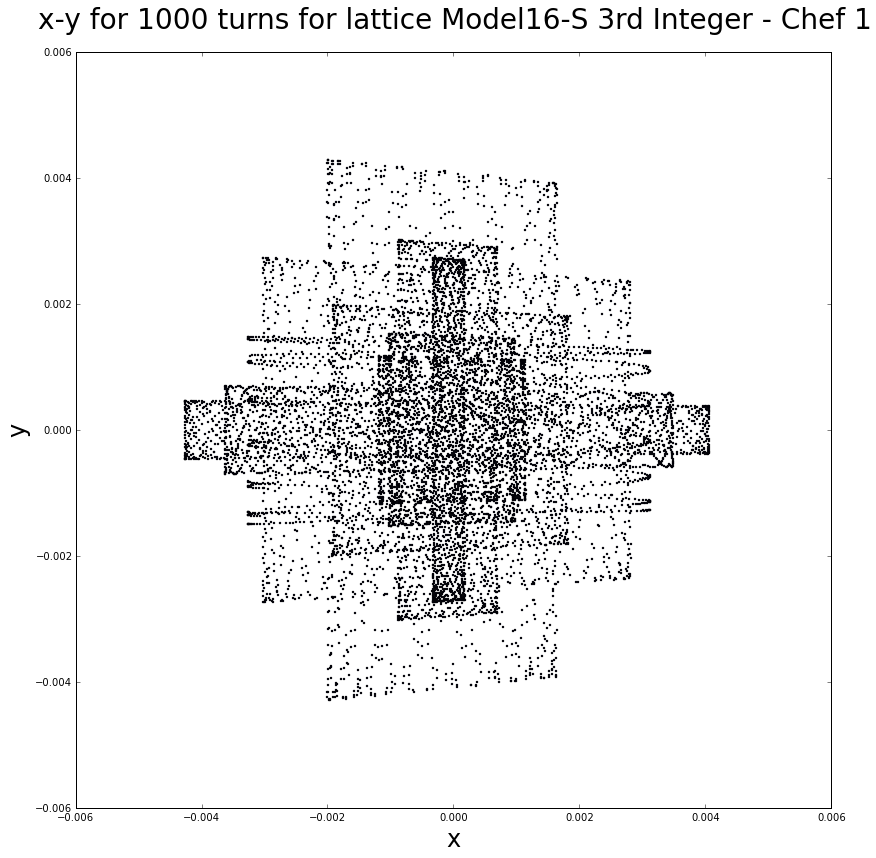

In [26]:
from base_diagnostics import options
from base_diagnostics import singleparticle

popts = options.Options()
popts.lattice_name = 'Model16-S 3rd Integer - Chef 1'
popts.ID = None
popts.path = None
popts.turns = opts.turns 
popts.norm = False
popts.save = True
popts.variance = 0.01
popts.lattice_simulator = lattice_simulator
popts.relpath = opts.output_dir

popts.save = True
popts.plots = ['x','y']
popts.num = 10
popts.scale = 2

singleparticle.plot_Poincare(popts)

We see very nice agreement with the 3rd order taylor maps (see [3rd Order Propagation](3rd Order Propagation.ipynb)) applied to the same lattice. Changing the map_order has no effect on the simulation. Thus, the chef propagators are working, and the lattice map_order is essentially deprecated by specifiying the string attribute `elem.set_string_attribute("extractor_type", "chef_propagate")` for each element in the lattice.